# Chapter06 Convolutional Neural Networks（卷积神经网络）

## 从全连接层到卷积

对于高维数据而言全连接层并不是一个很好的选择。例如假设我们有一个足够充分的照片数据集，每张照片具有百万级像素，这意味着网络的每次输入都有一百万个维度。 即使将隐藏层维度降低到1000，这个全连接层也将有10^6 * 10^3 = 10^9个参数。 想要训练这个模型将不可实现，因为需要有大量的GPU、分布式优化训练的经验和超乎常人的耐心。

然而，如今人类和机器都能很好地区分猫和狗：这是因为图像中本就拥有丰富的结构，而这些结构可以被人类和机器学习模型使用。 卷积神经网络（convolutional neural networks，CNN）是机器学习利用自然图像中一些已知结构的创造性方法。

适合于计算机视觉的神经网络架构包括以下两点：

1. 平移不变性（translation invariance）：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。

2. 局部性（locality）：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。

对于MLP而言，输入是二维图像 ${\mathbf{X}}$，其隐藏表示${\mathbf{H}}$在数学上是一个矩阵，在代码中表示为二维张量。 其中${\mathbf{X}}$和${\mathbf{H}}$具有相同的形状。

使用${[\mathbf{X}]_{i, j}}$和${[\mathbf{H}]_{i, j}}$分别表示输入图像和隐藏表示中位置（i,j）处的像素。 为了使每个隐藏神经元都能接收到每个输入像素的信息，我们将参数从权重矩阵替换为四阶权重张量W。假设包含偏置参数U，我们可以将全连接层形式化地表示为:

$${\begin{split}\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}\end{split}}$$

其中，i,j代表输出的点在输出矩阵中的位置，k,l代表输入点在输入的图（或者矩阵）中的位置。因此权重矩阵W记录输入中的每一个点对于输出中的每一个点的影响（也就是权重）。

通过重新索引下标（k,l）,使k=i+a, l=j+b，可得${[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}}$.  

### 平移不变性

现在引用上述的第一个原则：平移不变性。 这意味着检测对象在输入X中的平移，应该仅导致隐藏表示H中的平移。也就是说，V和U实际上不依赖于(i,j)的值，即${[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}}$。并且U是一个常数，比如u。因此，我们可以简化H定义为：

$${[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}.}$$

这实际上就是互相关计算（cross-correlation）

卷积（convolution）是其水平和上下倒置后的形式：
$${[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{-a, -b} [\mathbf{X}]_{i+a, j+b}.}$$

### 局部性

现在引用上述的第二个原则：局部性。如上所述，为了收集用来训练参数${[\mathbf{H}]_{i, j}}$的相关信息，我们不应偏离到距(i,j)很远的地方。这意味着在${|a|> \Delta}$或${|b|> \Delta}$的范围之外，我们可以设置${[\mathbf{V}]_{a, b} = 0}$。因此，我们可以将${[\mathbf{H}]_{i, j}}$重写为

$${[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.}$$

这实际上就是卷积层（convolutional layer）. V被称为卷积核（convolution kernel）或者滤波器（filter），亦或简单地称之为该卷积层的权重，通常该权重是可学习的参数.

## 卷积层

- feature map -- 特征映射

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。 当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。

在以下例子中：

![](https://d2l.ai/_images/correlation.svg)

$${\begin{split}0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.\end{split}}$$

互相关运算（卷积）后，输出大小nh * nw等于输入大小减去卷积核大小kh * kw，即：

$${(n_h-k_h+1) \times (n_w-k_w+1).}$$

- receptive field -- 感受野

有时候我们会将卷积核称为感受野

以下实现卷积运算

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [10]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

根据卷积运算我们定义一个卷积层，其中包含的参数为权重，权重大小又核大小决定，以及偏置。最后，在前向传播函数中计算卷积运算。

In [11]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

接下来，我们尝试利用卷积运算从图像中识别边缘。

首先，构建一个6x8的图像，黑色用0、白色用1表示


In [12]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [13]:
# 定义1x2的卷积核
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

利用卷积运算，我们可以识别到图像的边缘，其中1表示白到黑的边，-1表示黑到白的边。

下一步，我们尝试给定输入和输出学习卷积核，而非提前定义。

In [14]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 10.292
epoch 4, loss 1.728
epoch 6, loss 0.291
epoch 8, loss 0.049
epoch 10, loss 0.008


In [15]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9847, -0.9819]])

通过10个迭代周期，我们最后学习的卷积核 `tensor([[ 0.9847, -0.9819]])` 与预先定义的 (1,-1) 极为接近。

## 填充和步幅

- padding -- 填充 

![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/arbitrary_padding_no_strides.gif)

在应用多层卷积时，我们常常丢失边缘像素。 由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。 但随着我们应用许多连续卷积层，累积丢失的像素数就多了。 解决这个问题的简单方法即为填充（padding）：在输入图像的边界填充元素（通常填充元素是0）

![](https://zh.d2l.ai/_images/conv-pad.svg)

我们通常会添加${p_h=k_h-1}$行和${p_w=k_w-1}$列的填充，如此可以使得输入和输出具有相同的高度和宽度。

$${(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。}$$

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5或7。 选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

- stride -- 步幅

![](https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_strides.gif)

步幅指的就是每次卷积核在输入中滑动的元素个数.以下是垂直步幅为3，水平步幅为2的二维互相关运算.

![](https://zh.d2l.ai/_images/conv-stride.svg)

在计算资源允许的情况，我们还是会选取步幅为1，以获得更多信息。

## 多输入多输出通道

当我们添加通道时，我们的输入和隐藏表示都变成了三维张量。例如，每个RGB输入图像具有的${3\times h\times w}$形状。我们将这个大小为的轴称为通道（channel）维度。

### 多输入
![](https://zh.d2l.ai/_images/conv-multi-in.svg)

多输入通道的卷积实际上就是把各个通道卷积进行求和。

### 多输出

每个核生成一个输出通道

## 池化层 （Pooling）

池化层具有双重目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。

池化层也和卷积层一般在输入上以窗口根据一定的padding和stride滑动，并生成一个输出（最大值/平均值）

- 最大池化层（maximum pooling）

![](https://d2l.ai/_images/pooling.svg)

- 平均池化层（average pooling）

如上，但求每个窗口的平均值


## LeNet

LeNet接受输入为 28x28 的图片，输出10维的分类预测结果。

![](https://d2l.ai/_images/lenet.svg)

具体来说LeNet可以分成三个块：
1. 第一个块包括输入（1,1,28,28）一个卷积层（1,6,28,28）、sigmoid激活函数和平均池化层(1,6,14,14)。注意卷积层将单通道的输入变为6通道

```python
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2)
```

2. 第二个块包括一个卷积层（1,16,10,10）、sigmoid激活函数和平均池化层(1,16,5,5)。注意最后的Flatten将池化层的输出拉平为1d变量（16x5x5=400）

```python
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten()
```

3. 第三个块包括三个全连接层，实际上就是一个包含两个隐藏层的MLP。最终输出（1，10）的分类预测结果

```python
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
```

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

可以将每一层的输出的shape都打印出来看看

In [2]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


在Fashion-MNIST这个数据集上测试LeNet的表现。

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [5]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.450, train acc 0.833, test acc 0.794
58994.4 examples/sec on cuda:0


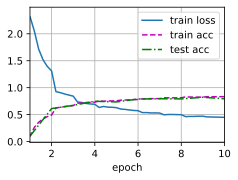

In [6]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.366, train acc 0.865, test acc 0.854
71639.8 examples/sec on cuda:0


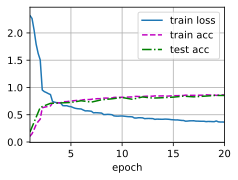

In [7]:
# 增加迭代周期到20
num_epochs = 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

上述的实验表明增加迭代周期到20可以提高模型预测精度。

训练误差和测试误差较为接近，说明LeNet并不会带来明显的overfitting。
